# Explainable Machine Learning for Diabetes Risk Stratification in Population Health

# Problem Understanding

In [716]:
"""              📌 Trả lời rõ:

Bài toán gì?
→ Classification (Binary: Diabetes / No Diabetes)

Biến mục tiêu là gì?
→ Diabetes_binary

Đánh đổi gì quan trọng?

Recall (bắt bệnh nhân)

Precision (giảm báo động giả)

👉 Với y tế: Recall class 1 quan trọng hơn Accuracy                    """

'              📌 Trả lời rõ:\n\nBài toán gì?\n→ Classification (Binary: Diabetes / No Diabetes)\n\nBiến mục tiêu là gì?\n→ Diabetes_binary\n\nĐánh đổi gì quan trọng?\n\nRecall (bắt bệnh nhân)\n\nPrecision (giảm báo động giả)\n\n👉 Với y tế: Recall class 1 quan trọng hơn Accuracy                    '

# SET UP

In [718]:
# Core
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Statistical modeling (for odds ratio, p-values)
import statsmodels.api as sm

# Preprocessing
from sklearn.preprocessing import StandardScaler

# Train-test & validation
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

# Metrics
from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    roc_auc_score,
    roc_curve,
    classification_report,
    mean_squared_error,
    r2_score
)

# Plot style
sns.set()
plt.style.use("ggplot")

# Warning 
import warnings
warnings.simplefilter(action = "ignore")

# If you are using Jupyter Notebook
%matplotlib inline


In [719]:
# read  the dataset 

PATH = "diabetes_binary_health_indicators_BRFSS2015.csv"
df = pd.read_csv(PATH)
df.head()

,Diabetes_binary,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,0.0,1.0,1.0,1.0,40.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,5.0,18.0,15.0,1.0,0.0,9.0,4.0,3.0
1,0.0,0.0,0.0,0.0,25.0,1.0,0.0,0.0,1.0,0.0,...,0.0,1.0,3.0,0.0,0.0,0.0,0.0,7.0,6.0,1.0
2,0.0,1.0,1.0,1.0,28.0,0.0,0.0,0.0,0.0,1.0,...,1.0,1.0,5.0,30.0,30.0,1.0,0.0,9.0,4.0,8.0
3,0.0,1.0,0.0,1.0,27.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,0.0,0.0,0.0,0.0,11.0,3.0,6.0
4,0.0,1.0,1.0,1.0,24.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,3.0,0.0,0.0,0.0,11.0,5.0,4.0


# Data Cleaning

## Detect Outlier

In [722]:
# Outlier Detection
# IQR 
for feature in df:
    Q1 = df[feature].quantile(0.25)
    Q3 = df[feature].quantile(0.75)
    IQR = Q3-Q1
    lower = Q1 - 1.5*IQR
    upper = Q3 + 1.5*IQR
    if df[(df[feature] > upper)].any(axis = None):
        print(feature, "yes")
    else:
        print(feature, "no")
     

Diabetes_binary yes
HighBP no
HighChol no
CholCheck no
BMI yes
Smoker no
Stroke yes
HeartDiseaseorAttack yes
PhysActivity no
Fruits no
Veggies no
HvyAlcoholConsump yes
AnyHealthcare no
NoDocbcCost yes
GenHlth yes
MentHlth yes
PhysHlth yes
DiffWalk yes
Sex no
Age no
Education no
Income no


In [723]:
features_outlier = ["BMI"]
for feature in features_outlier:
    Q1 = df[feature].quantile(0.25)
    Q3 = df[feature].quantile(0.75)
    IQR = Q3 - Q1 
    upper = Q3 + IQR * 1.5
    lower = Q1 - IQR* 1.5
    df.loc[df[feature] > upper, feature] = upper
    df.loc[df[feature] < lower, feature] = lower


# EDA

### data describe

In [726]:
describe_dataset()

{'dataset_name': 'Diabetes Health Indicators Dataset',
 'source': 'Behavioral Risk Factor Surveillance System (BRFSS), conducted annually by the CDC (Centers for Disease Control and Prevention, USA)',
 'purpose': 'Analyze and predict diabetes status using health indicators, lifestyle habits, related diseases, and demographic factors.',
 'target_variable': {'name': 'Diabetes_binary',
  'type': 'binary',
  'classes': {0: 'No diabetes', 1: 'Diabetes'}},
 'feature_groups': {'health_indicators': ['HighBP',
   'HighChol',
   'BMI',
   'GenHlth',
   'PhysHlth',
   'MentHlth'],
  'lifestyle_habits': ['Smoker',
   'PhysActivity',
   'HvyAlcoholConsump',
   'Fruits',
   'Veggies'],
  'related_diseases': ['HeartDiseaseorAttack', 'Stroke', 'DiffWalk'],
  'demographics': ['Age', 'Sex', 'Education', 'Income']}}

In [727]:
def describe_dataset():
    """
    Returns a description of the Diabetes Health Indicators Dataset
    with a binary target variable.
    """
    description = {
        "dataset_name": "Diabetes Health Indicators Dataset",
        "source": (
            "Behavioral Risk Factor Surveillance System (BRFSS), "
            "conducted annually by the CDC (Centers for Disease Control and Prevention, USA)"
        ),
        "purpose": (
            "Analyze and predict diabetes status using health indicators, "
            "lifestyle habits, related diseases, and demographic factors."
        ),
        "target_variable": {
            "name": "Diabetes_binary",
            "type": "binary",
            "classes": {
                0: "No diabetes",
                1: "Diabetes"
            }
        },
        "feature_groups": {
            "health_indicators": [
                "HighBP",
                "HighChol",
                "BMI",
                "GenHlth",
                "PhysHlth",
                "MentHlth"
            ],
            "lifestyle_habits": [
                "Smoker",
                "PhysActivity",
                "HvyAlcoholConsump",
                "Fruits",
                "Veggies"
            ],
            "related_diseases": [
                "HeartDiseaseorAttack",
                "Stroke",
                "DiffWalk"
            ],
            "demographics": [
                "Age",
                "Sex",
                "Education",
                "Income"
            ]
        }
    }

    return description


In [728]:
data_visualize = df.copy()
data_visualize.head()

,Diabetes_binary,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,0.0,1.0,1.0,1.0,40.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,5.0,18.0,15.0,1.0,0.0,9.0,4.0,3.0
1,0.0,0.0,0.0,0.0,25.0,1.0,0.0,0.0,1.0,0.0,...,0.0,1.0,3.0,0.0,0.0,0.0,0.0,7.0,6.0,1.0
2,0.0,1.0,1.0,1.0,28.0,0.0,0.0,0.0,0.0,1.0,...,1.0,1.0,5.0,30.0,30.0,1.0,0.0,9.0,4.0,8.0
3,0.0,1.0,0.0,1.0,27.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,0.0,0.0,0.0,0.0,11.0,3.0,6.0
4,0.0,1.0,1.0,1.0,24.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,3.0,0.0,0.0,0.0,11.0,5.0,4.0


In [729]:
corr_matrix = data_visualize.corr()
corr_matrix["Diabetes_binary"].sort_values(ascending = False)

Diabetes_binary         1.000000
GenHlth                 0.293569
HighBP                  0.263129
BMI                     0.234641
DiffWalk                0.218344
HighChol                0.200276
Age                     0.177442
HeartDiseaseorAttack    0.177282
PhysHlth                0.171337
Stroke                  0.105816
MentHlth                0.069315
CholCheck               0.064761
Smoker                  0.060789
NoDocbcCost             0.031433
Sex                     0.031430
AnyHealthcare           0.016255
Fruits                 -0.040779
Veggies                -0.056584
HvyAlcoholConsump      -0.057056
PhysActivity           -0.118133
Education              -0.124456
Income                 -0.163919
Name: Diabetes_binary, dtype: float64

In [731]:
data_visualize.Diabetes_binary.value_counts()*100/ len(data_visualize)
# dataset skwed to not have Diabetes
data_visualize.columns

Index(['Diabetes_binary', 'HighBP', 'HighChol', 'CholCheck', 'BMI', 'Smoker',
       'Stroke', 'HeartDiseaseorAttack', 'PhysActivity', 'Fruits', 'Veggies',
       'HvyAlcoholConsump', 'AnyHealthcare', 'NoDocbcCost', 'GenHlth',
       'MentHlth', 'PhysHlth', 'DiffWalk', 'Sex', 'Age', 'Education',
       'Income'],
      dtype='object')

In [829]:
import numpy as np
import pandas as pd

data_visualize["BMI_category"] = pd.cut(
    data_visualize["BMI"],
    bins=[0, 18.5, 25, 30, np.inf],
    labels=["Underweight", "Normal", "Overweight", "Obese"]
)

data_visualize.head()

,Diabetes_binary,HighBP,HighChol,BMI,Stroke,HeartDiseaseorAttack,PhysActivity,GenHlth,MentHlth,PhysHlth,DiffWalk,Age,Education,Income,Age_BMI,MetabolicRisk,LifestyleRisk,BMI_category,NewBMI
0,0.0,1.0,1.0,40.0,0.0,0.0,0.0,5.0,18.0,15.0,1.0,9.0,4.0,3.0,360.0,4.0,2.0,Obese,Obese
1,0.0,0.0,0.0,25.0,0.0,0.0,1.0,3.0,0.0,0.0,0.0,7.0,6.0,1.0,175.0,0.0,1.0,Normal,Normal
2,0.0,1.0,1.0,28.0,0.0,0.0,0.0,5.0,30.0,30.0,1.0,9.0,4.0,8.0,252.0,3.0,1.0,Overweight,Overweight
3,0.0,1.0,0.0,27.0,0.0,0.0,1.0,2.0,0.0,0.0,0.0,11.0,3.0,6.0,297.0,2.0,0.0,Overweight,Overweight
4,0.0,1.0,1.0,24.0,0.0,0.0,1.0,2.0,3.0,0.0,0.0,11.0,5.0,4.0,264.0,2.0,0.0,Normal,Normal


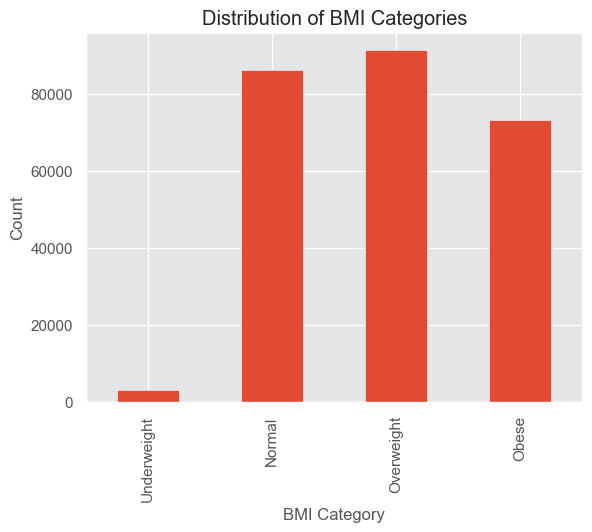

In [854]:
order = ["Underweight", "Normal", "Overweight", "Obese"]

data_visualize['BMI_category'].value_counts().reindex(order).plot(kind='bar')

plt.xlabel('BMI Category')
plt.ylabel('Count')
plt.title('Distribution of BMI Categories')
plt.show()


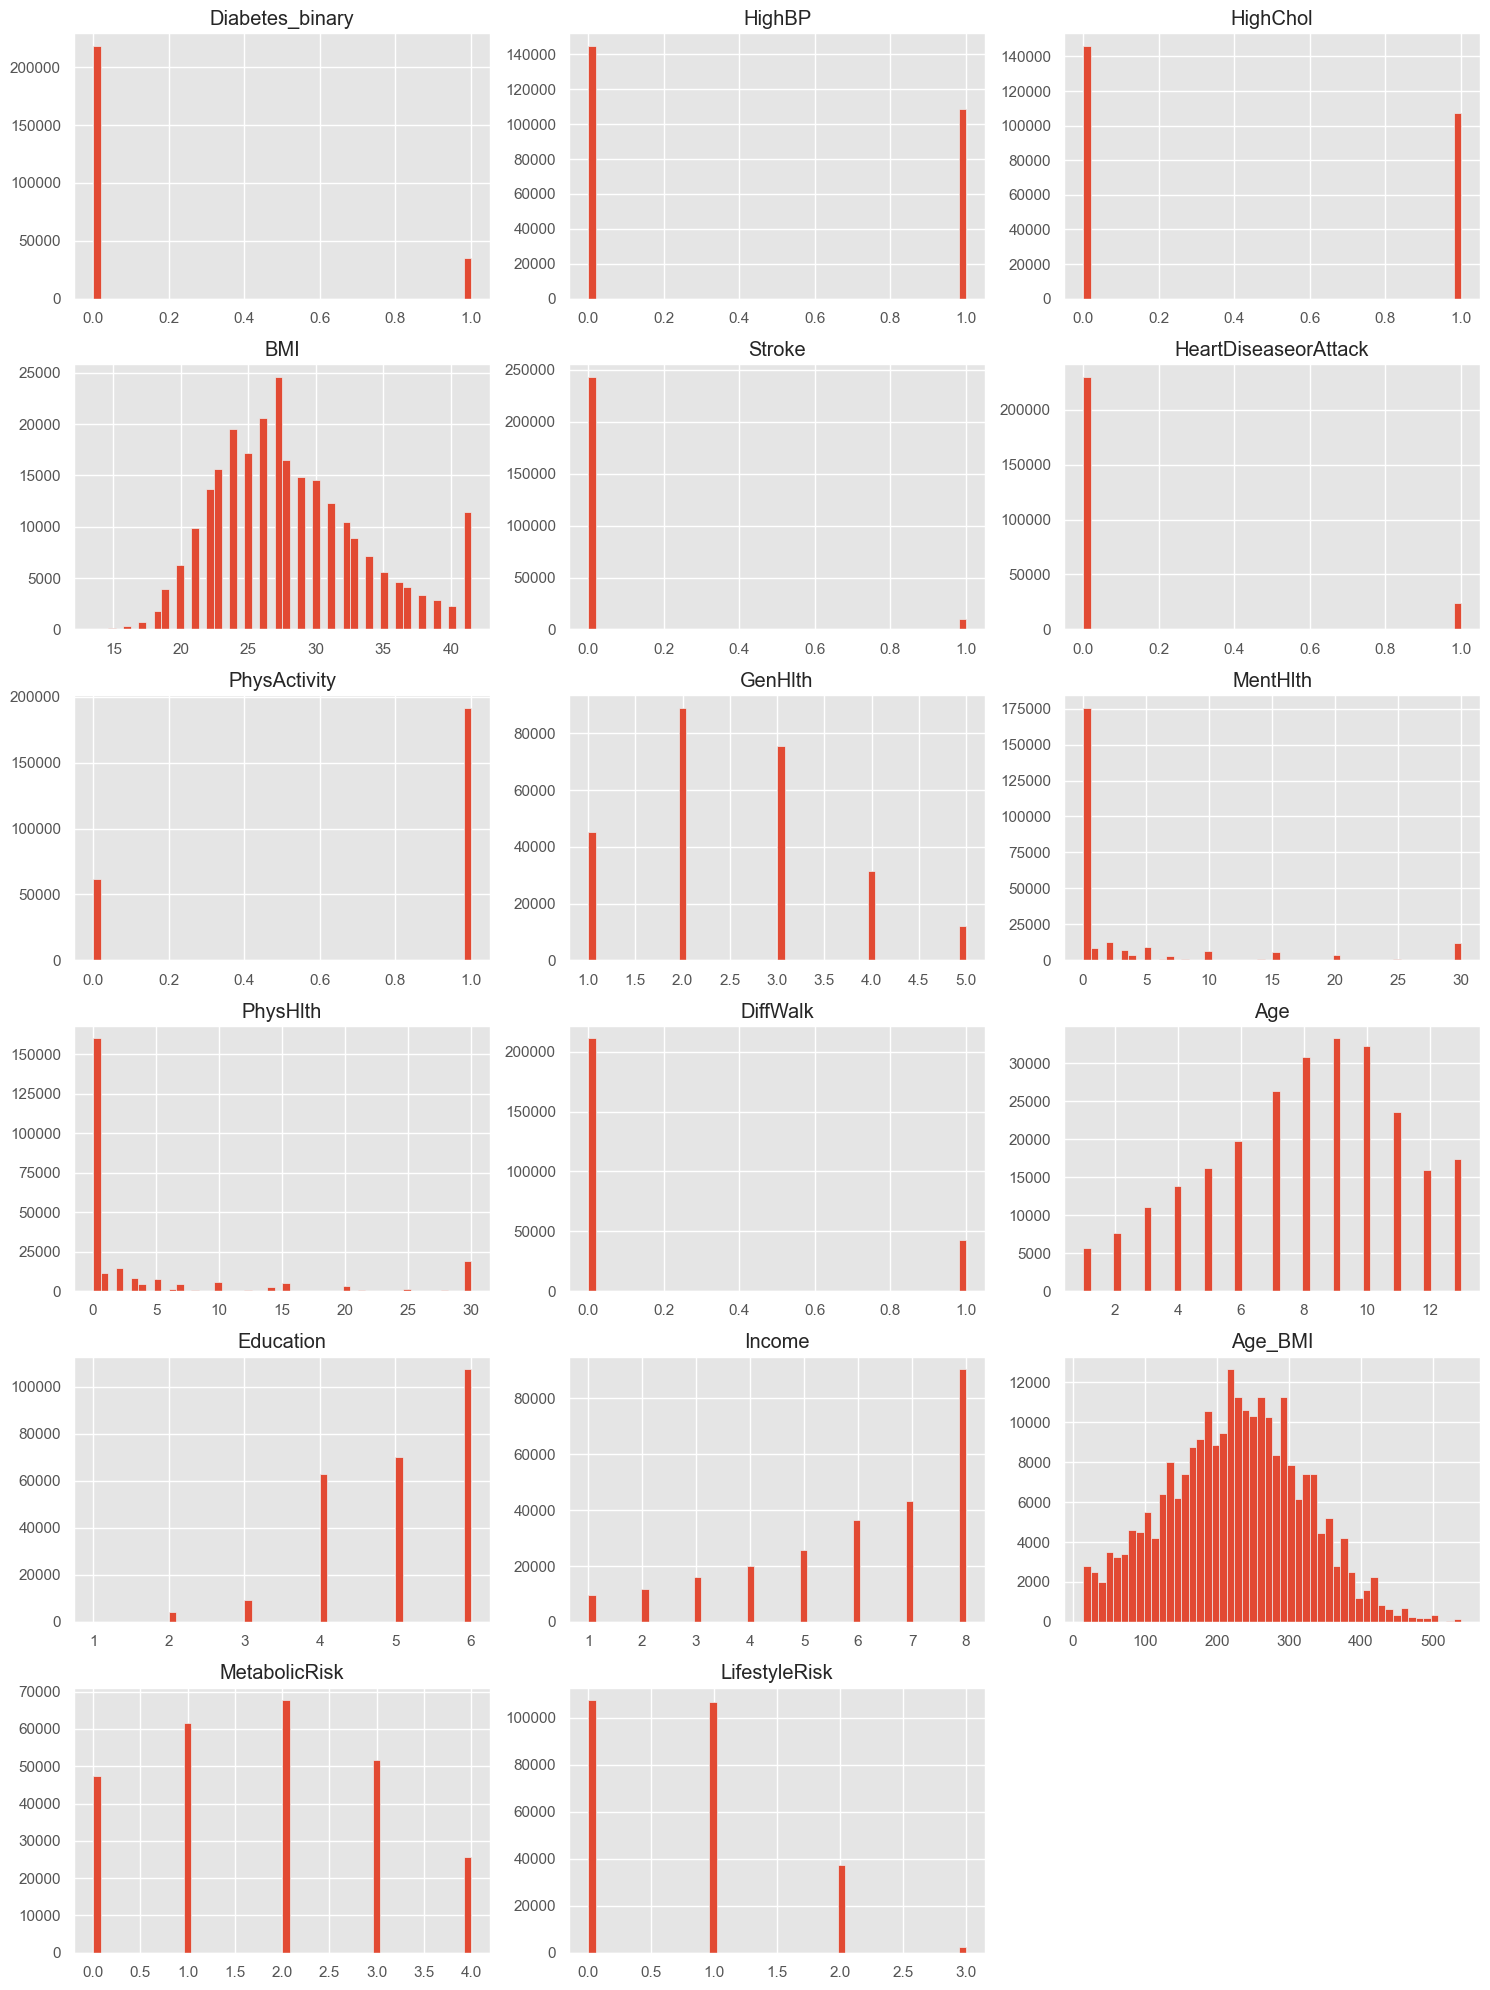

In [856]:
import matplotlib.pyplot as plt

# --- Tạo figure với 2 subplot ---
fig, axes = plt.subplots(2, 1, figsize=(15, 20))  # 2 hàng, 1 cột

# --- Subplot 1: Histogram tất cả numeric columns ---
data_visualize[data_visualize.select_dtypes(include=np.number).columns].hist(
    bins=50, ax=axes[0], layout=(int(len(data_visualize.select_dtypes(include=np.number).columns)/3)+1, 3)
)
axes[0].set_title("Histogram of Numeric Features")

# --- Subplot 2: Bar plot BMI_category ---
order = ['Underweight', 'Normal', 'Overweight', 'Obese']  # ví dụ order
data_visualize['BMI_category'].value_counts().reindex(order).plot(
    kind='bar', ax=axes[1]
)
axes[1].set_xlabel('BMI Category')
axes[1].set_ylabel('Count')
axes[1].set_title('Distribution of BMI Categories')

plt.tight_layout()
plt.show()


In [735]:
# Phân bố BMI có dạng lệch phải (right-skewed), với phần lớn giá trị tập trung trong khoảng từ 20 đến 35. 
#Điều này cho thấy đa số đối tượng có BMI thuộc mức bình thường đến thừa cân.


#Biến Age đại diện cho các nhóm tuổi có thứ tự, thay vì tuổi chính xác. 
#Phân bố cho thấy phần lớn các cá nhân thuộc nhóm tuổi trung niên đến cao tuổi, 
#cho thấy bộ dữ liệu có xu hướng nghiêng về nhóm dân số lớn tuổi.


# Phân phối của PhysHlth lệch phải rất mạnh, với phần lớn giá trị tập trung tại 0 ngày, 
#cho thấy đa số người tham gia không gặp vấn đề sức khỏe thể chất trong tháng qua.
#Một nhóm nhỏ báo cáo tình trạng sức khỏe kém kéo dài, thể hiện qua đỉnh tại 30 ngày.


# MentHlth 
#Phân phối của MentHlth lệch phải rất mạnh, với phần lớn giá trị tập trung tại 0 ngày, 
#cho thấy đa số người tham gia không gặp vấn đề về sức khỏe tinh thần trong tháng qua.
#Một nhóm nhỏ gặp vấn đề tinh thần kéo dài, thể hiện qua đỉnh tại 30 ngày.

#High BP
#Phân phối dữ liệu (Distribution): Biến HighBP là biến phân loại nhị phân
#biểu đồ cho thấy số lượng người không bị cao huyết áp (giá trị 0) cao hơn so với nhóm có cao huyết áp (giá trị 1).

# GenhLth
#Loại biến và Phân phối (Distribution):
#GenHlth là một biến thứ bậc (ordinal categorical variable) với 5 mức độ.

#Phân phối của biến này có dạng lệch phải (right-skewed). 
#Phần lớn các quan sát tập trung vào nhóm sức khỏe từ "Tốt" đến "Rất tốt" (mức 1, 2, 3), 
#và giảm dần khi về phía sức khỏe kém (mức 4, 5).

In [736]:
data_visualize.columns 

Index(['Diabetes_binary', 'HighBP', 'HighChol', 'CholCheck', 'BMI', 'Smoker',
       'Stroke', 'HeartDiseaseorAttack', 'PhysActivity', 'Fruits', 'Veggies',
       'HvyAlcoholConsump', 'AnyHealthcare', 'NoDocbcCost', 'GenHlth',
       'MentHlth', 'PhysHlth', 'DiffWalk', 'Sex', 'Age', 'Education', 'Income',
       'BMI_category', 'NewBMI'],
      dtype='object')

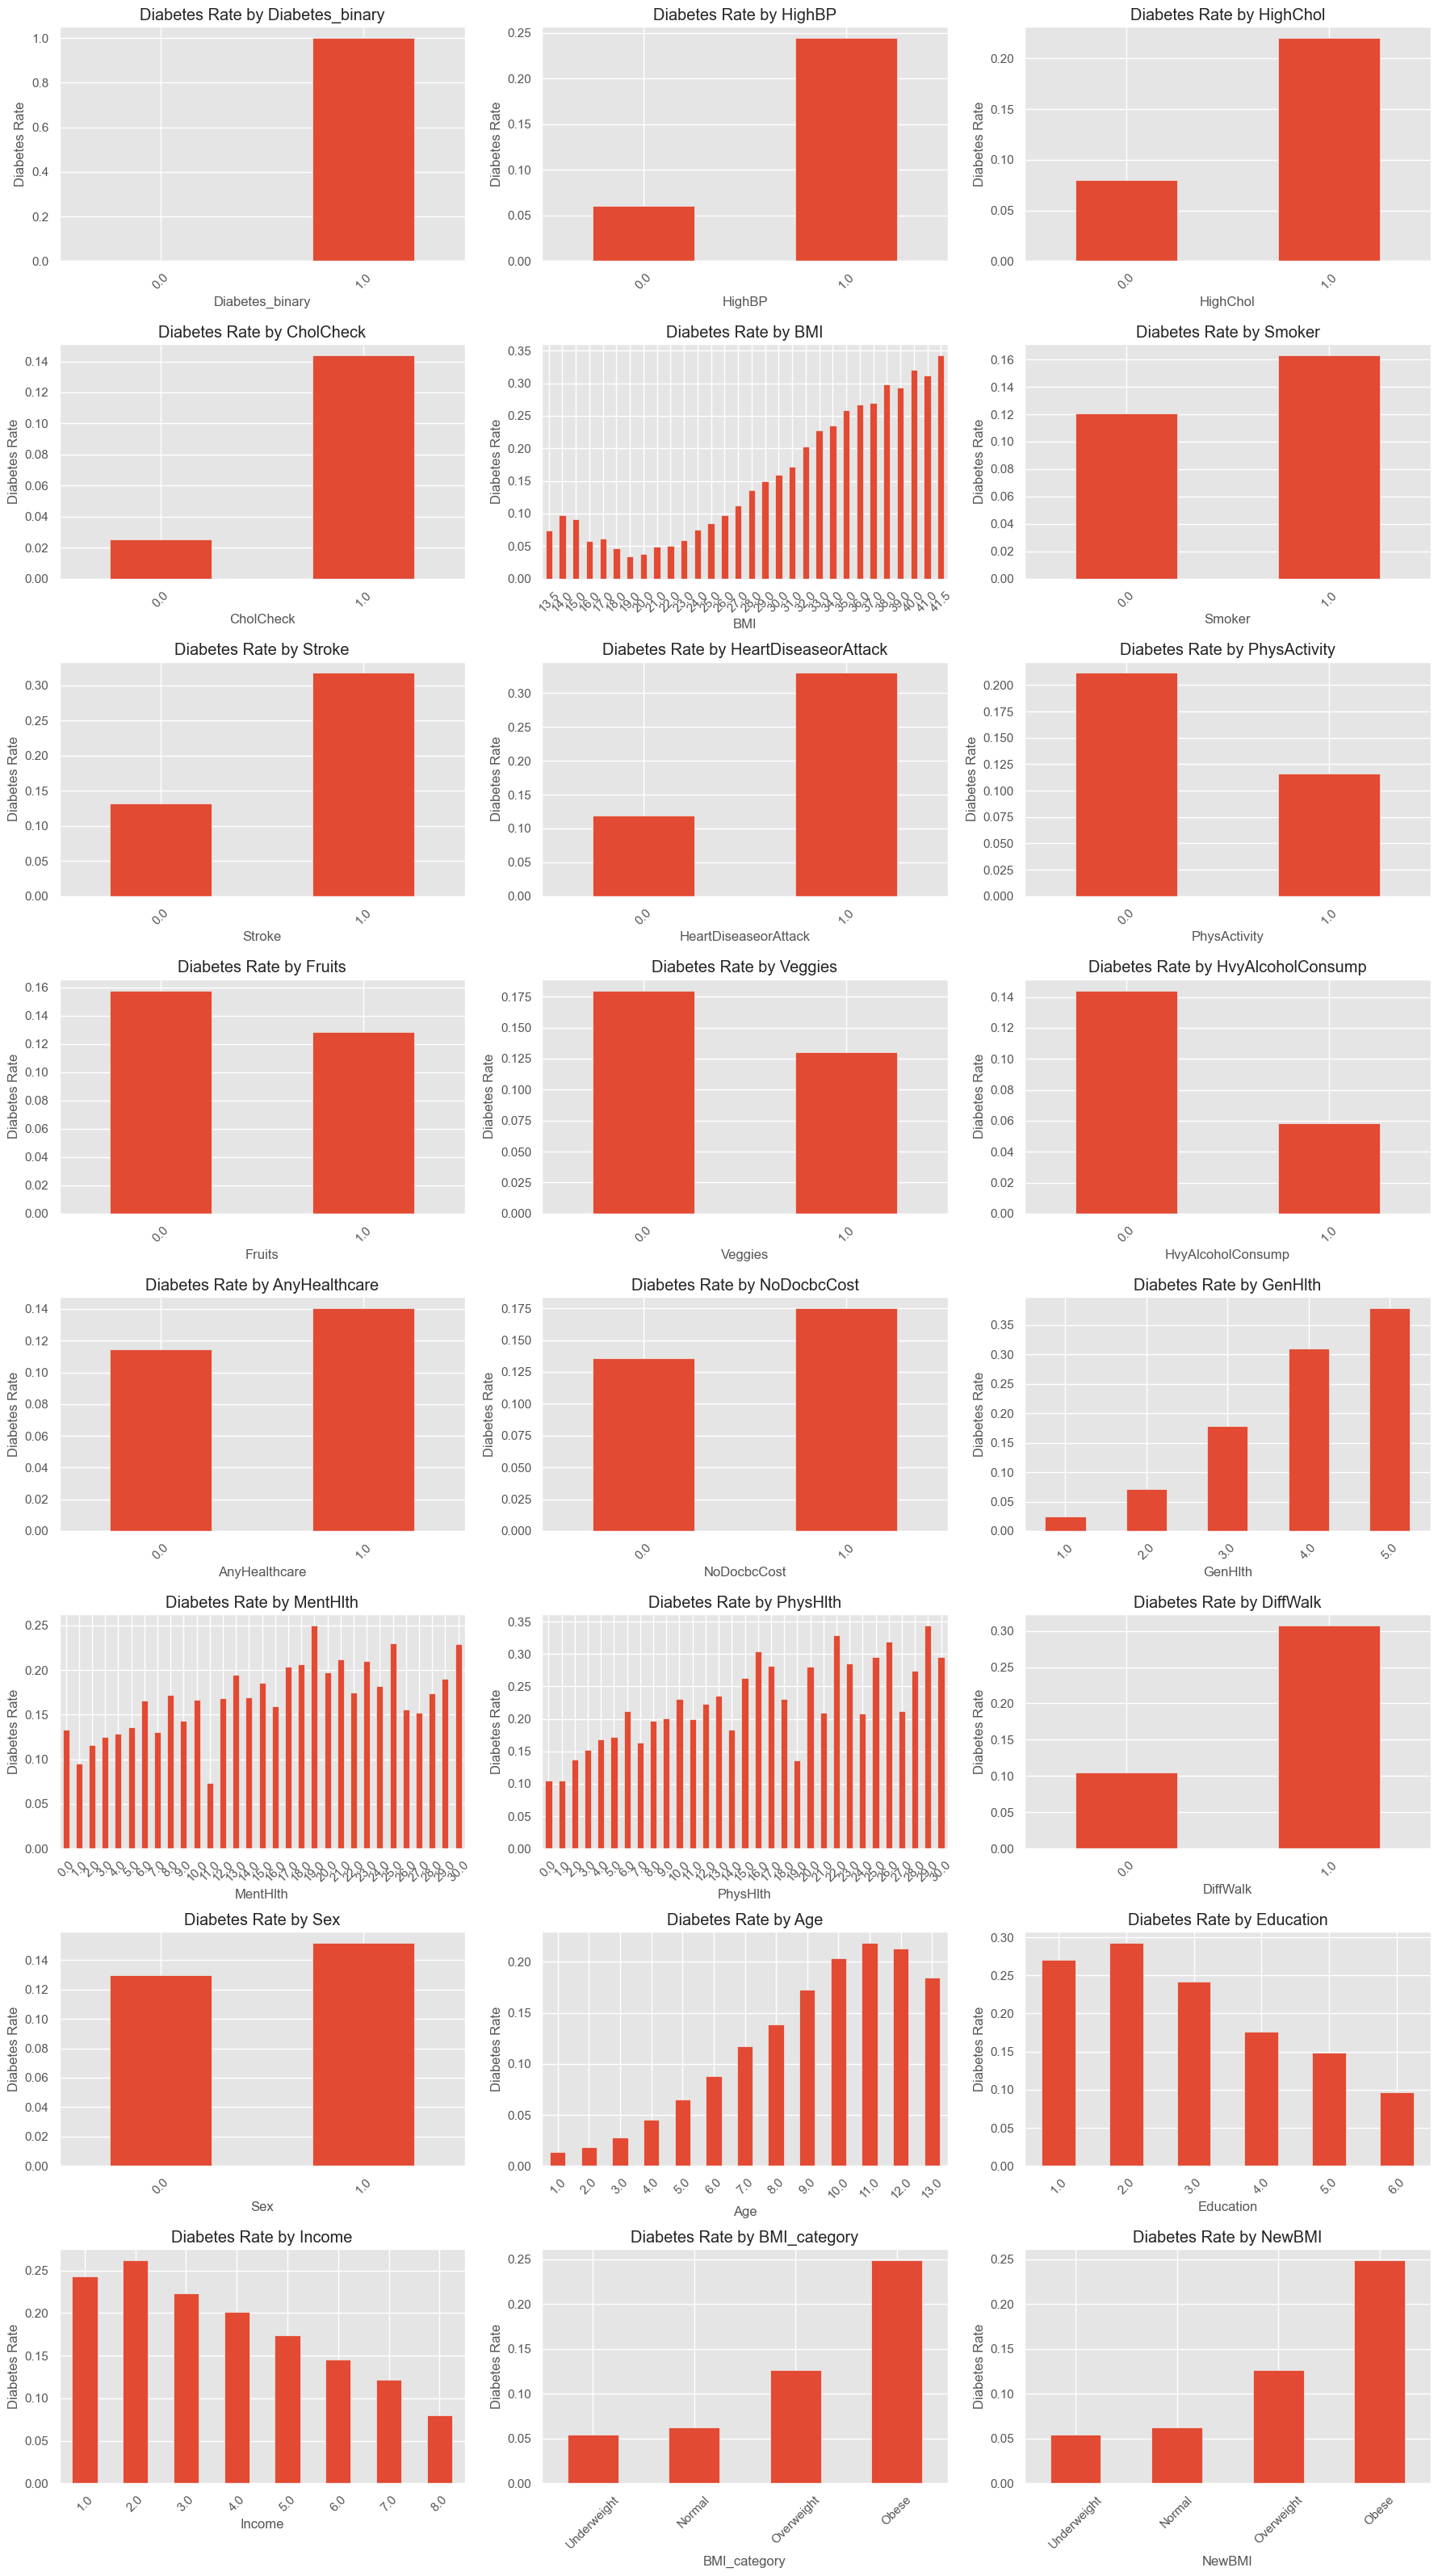

In [738]:
features = data_visualize.columns
import matplotlib.pyplot as plt

n_cols = 3
n_rows = (len(features) + n_cols - 1) // n_cols

plt.figure(figsize=(18, 4 * n_rows))

for i, feature in enumerate(features, 1):
    plt.subplot(n_rows, n_cols, i)

    rate = data_visualize.groupby(feature)["Diabetes_binary"].mean()
    rate.plot(kind="bar")

    plt.xlabel(feature)
    plt.ylabel("Diabetes Rate")
    plt.title(f"Diabetes Rate by {feature}")
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()



In [739]:
# tạm thời là như này  cho EDA


## Attribute Combinations

In [741]:
data_visualize["Age_BMI"] = data_visualize["Age"] * data_visualize["BMI"]
# Người trẻ béo ≠ người già béo
data_visualize["MetabolicRisk"] = (
    data_visualize["HighBP"] +
    data_visualize["HighChol"] +
    data_visualize["BMI_category"].map({
        "Underweight": 0,
        "Normal": 0,
        "Overweight": 1,
        "Obese": 2
    })
)
# Feature MetabolicRisk  tính theo y khoa

# Phản ánh sức khỏe tổng thể kém
data_visualize["LifestyleRisk"] = (
    data_visualize["Smoker"] +
    (1 - data_visualize["PhysActivity"]) +
    data_visualize["HvyAlcoholConsump"]
)
# phản ánh lối sống 

# đại khái là thêm các combinition có thử corr cao hơn hay không.


In [742]:
data_visualize.corr(numeric_only = True)["Diabetes_binary"].sort_values(ascending = False)

Diabetes_binary         1.000000
MetabolicRisk           0.320295
GenHlth                 0.293569
Age_BMI                 0.280484
HighBP                  0.263129
BMI                     0.234641
DiffWalk                0.218344
HighChol                0.200276
Age                     0.177442
HeartDiseaseorAttack    0.177282
PhysHlth                0.171337
Stroke                  0.105816
LifestyleRisk           0.092029
MentHlth                0.069315
CholCheck               0.064761
Smoker                  0.060789
NoDocbcCost             0.031433
Sex                     0.031430
AnyHealthcare           0.016255
Fruits                 -0.040779
Veggies                -0.056584
HvyAlcoholConsump      -0.057056
PhysActivity           -0.118133
Education              -0.124456
Income                 -0.163919
Name: Diabetes_binary, dtype: float64

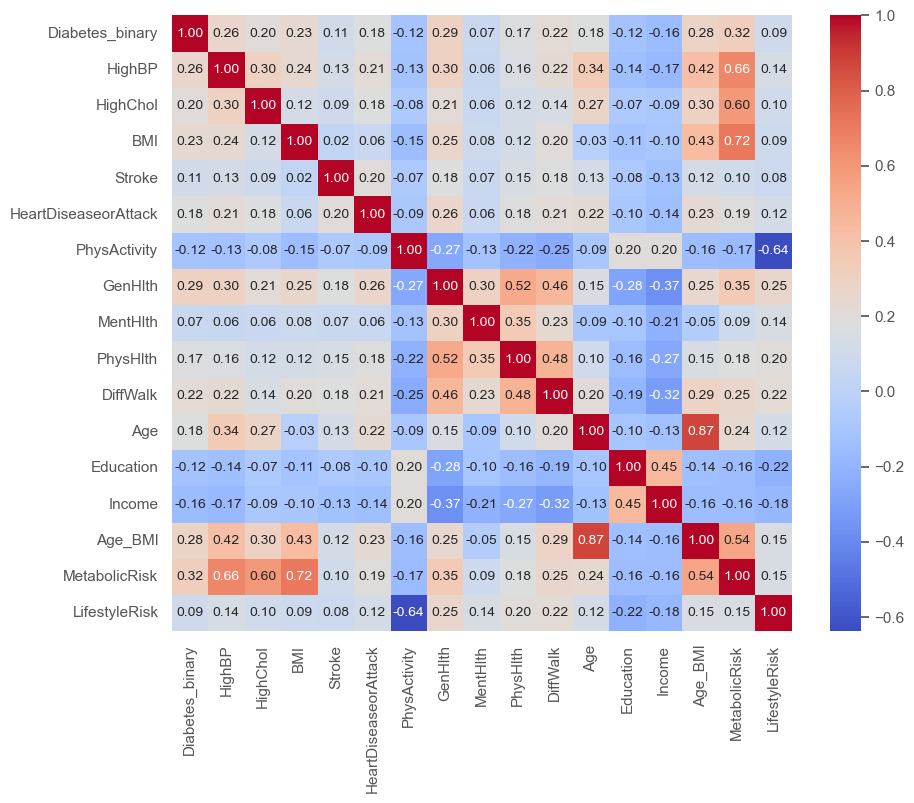

Diabetes_binary         1.000000
MetabolicRisk           0.320295
GenHlth                 0.293569
Age_BMI                 0.280484
HighBP                  0.263129
BMI                     0.234641
DiffWalk                0.218344
HighChol                0.200276
Age                     0.177442
HeartDiseaseorAttack    0.177282
PhysHlth                0.171337
Stroke                  0.105816
LifestyleRisk           0.092029
MentHlth                0.069315
PhysActivity           -0.118133
Education              -0.124456
Income                 -0.163919
Name: Diabetes_binary, dtype: float64

In [743]:
# Danh sách các cột features drop
cols_to_drop = ['NoDocbcCost', 'AnyHealthcare', 'Fruits', 'Veggies', 
                'HvyAlcoholConsump', "Sex", 'BMI_category', 'NewBMI', "CholCheck", "Smoker"]
corr_matrix = data_visualize.drop(columns=cols_to_drop).corr()
data_visualize.drop(columns=cols_to_drop, inplace = True)
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.show()
data_visualize.corr(numeric_only = True)["Diabetes_binary"].sort_values(ascending = False)

# Modeling

In [745]:
feature_cols = data_visualize.columns.drop("Diabetes_binary")

X = data_visualize[feature_cols]
y = data_visualize["Diabetes_binary"]


In [746]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)
X_test.shape, y_test.shape

((50736, 16), (50736,))

In [747]:
y_train.value_counts(normalize=True)


Diabetes_binary
0.0    0.860666
1.0    0.139334
Name: proportion, dtype: float64

## Scale Data

In [749]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


## train model 

In [751]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression(
    max_iter=1000,
    class_weight="balanced"   # rất quan trọng
)

log_reg.fit(X_train_scaled, y_train)


LogisticRegression(class_weight='balanced', max_iter=1000)

In [752]:
from sklearn.metrics import classification_report, confusion_matrix

y_pred_train = log_reg.predict(X_train_scaled)


y_pred = log_reg.predict(X_test_scaled)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
print(accuracy_score(y_pred_train, y_train))
print(accuracy_score(y_test, y_pred))

[[31851 11816]
 [ 1718  5351]]
              precision    recall  f1-score   support

         0.0       0.95      0.73      0.82     43667
         1.0       0.31      0.76      0.44      7069

    accuracy                           0.73     50736
   macro avg       0.63      0.74      0.63     50736
weighted avg       0.86      0.73      0.77     50736

0.7349219489120151
0.733246609902239


In [753]:
# ROC – AUC (RẤT ĐÁNG GIÁ)
from sklearn.metrics import roc_auc_score

y_prob = log_reg.predict_proba(X_test_scaled)[:, 1]

roc_auc_score(y_test, y_prob)


0.8188351464186173

# Modeling

In [756]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression(
    max_iter=1000,
    class_weight="balanced"
)

log_reg.fit(X_train_scaled, y_train)
y_pred_train = log_reg.predict(X_train_scaled)


y_pred = log_reg.predict(X_test_scaled)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
print(accuracy_score(y_pred_train, y_train))
print(accuracy_score(y_test, y_pred))
y_prob = log_reg.predict_proba(X_test_scaled)[:, 1]

roc_auc_score(y_test, y_prob)

[[31851 11816]
 [ 1718  5351]]
              precision    recall  f1-score   support

         0.0       0.95      0.73      0.82     43667
         1.0       0.31      0.76      0.44      7069

    accuracy                           0.73     50736
   macro avg       0.63      0.74      0.63     50736
weighted avg       0.86      0.73      0.77     50736

0.7349219489120151
0.733246609902239


0.8188351464186173

In [757]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(
    max_depth=6,
    min_samples_leaf=50,
    class_weight="balanced",
    random_state=42
)

dt.fit(X_train, y_train)
y_pred_train = dt.predict(X_train_scaled)


y_pred = dt.predict(X_test_scaled)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
print(accuracy_score(y_pred_train, y_train))
print(accuracy_score(y_test, y_pred))
y_prob = log_reg.predict_proba(X_test_scaled)[:, 1]

roc_auc_score(y_test, y_prob)


[[34633  9034]
 [ 3244  3825]]
              precision    recall  f1-score   support

         0.0       0.91      0.79      0.85     43667
         1.0       0.30      0.54      0.38      7069

    accuracy                           0.76     50736
   macro avg       0.61      0.67      0.62     50736
weighted avg       0.83      0.76      0.78     50736

0.7570659886471145
0.7580022075055187


0.8188351464186173

In [758]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=2,
    min_samples_leaf=4,
    class_weight="balanced",
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train, y_train)
y_pred_train = rf.predict(X_train_scaled)


y_pred = rf.predict(X_test_scaled)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
print(accuracy_score(y_pred_train, y_train))
print(accuracy_score(y_test, y_pred))
y_prob = log_reg.predict_proba(X_test_scaled)[:, 1]

roc_auc_score(y_test, y_prob)
# overfitting

[[43667     0]
 [ 7069     0]]
              precision    recall  f1-score   support

         0.0       0.86      1.00      0.93     43667
         1.0       0.00      0.00      0.00      7069

    accuracy                           0.86     50736
   macro avg       0.43      0.50      0.46     50736
weighted avg       0.74      0.86      0.80     50736

0.8606659965310628
0.8606709239987386


0.8188351464186173

In [759]:
from sklearn.ensemble import GradientBoostingClassifier

gb = GradientBoostingClassifier(
    n_estimators=200,
    learning_rate=0.05,
    max_depth=3,
    random_state=42
)

gb.fit(X_train, y_train)
y_pred_train = gb.predict(X_train_scaled)


y_pred = gb.predict(X_test_scaled)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
print(accuracy_score(y_pred_train, y_train))
print(accuracy_score(y_test, y_pred))
y_prob = log_reg.predict_proba(X_test_scaled)[:, 1]

roc_auc_score(y_test, y_prob)


[[43667     0]
 [ 7069     0]]
              precision    recall  f1-score   support

         0.0       0.86      1.00      0.93     43667
         1.0       0.00      0.00      0.00      7069

    accuracy                           0.86     50736
   macro avg       0.43      0.50      0.46     50736
weighted avg       0.74      0.86      0.80     50736

0.8606659965310628
0.8606709239987386


0.8188351464186173

In [760]:
from xgboost import XGBClassifier

xgb = XGBClassifier(
    n_estimators=300,
    max_depth=5,
    learning_rate=0.05,
    scale_pos_weight=len(y_train[y_train==0]) / len(y_train[y_train==1]),
    eval_metric="logloss",
    random_state=42
)

xgb.fit(X_train, y_train)
y_pred_train = xgb.predict(X_train_scaled)


y_pred = xgb.predict(X_test_scaled)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
print(accuracy_score(y_pred_train, y_train))
print(accuracy_score(y_test, y_pred))
y_prob = log_reg.predict_proba(X_test_scaled)[:, 1]

roc_auc_score(y_test, y_prob)

[[42326  1341]
 [ 5999  1070]]
              precision    recall  f1-score   support

         0.0       0.88      0.97      0.92     43667
         1.0       0.44      0.15      0.23      7069

    accuracy                           0.86     50736
   macro avg       0.66      0.56      0.57     50736
weighted avg       0.82      0.86      0.82     50736

0.8575961841690318
0.8553295490381583


0.8188351464186173

### hyperparameter tunning

In [762]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_dist = {
    "max_depth": randint(3, 10),
    "min_samples_leaf": randint(5, 25),
    "max_features": ["sqrt", 0.5]
}

rf = RandomForestClassifier(
    n_estimators=100,
    class_weight="balanced",
    random_state=42,
    n_jobs=-1  # dùng tất cả các core để chạy
)

random_rf = RandomizedSearchCV(
    rf,
    param_dist,
    n_iter=15,            # 👈 rất ít randomly chọn ra n_iter bộ khác nhau
    scoring="recall",  # ưu tiên phát hiện ra có bệnh
    cv=3,              # 👈 3 folder
    n_jobs=-1,
    random_state=42
)

random_rf.fit(X_train, y_train)

best_rf = random_rf.best_estimator_
best_rf

RandomForestClassifier(class_weight='balanced', max_depth=5, max_features=0.5,
                       min_samples_leaf=11, n_jobs=-1, random_state=42)

In [763]:
y_pred_train = best_rf.predict(X_train)


y_pred = best_rf.predict(X_test)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
print(accuracy_score(y_pred_train, y_train))
print(accuracy_score(y_test, y_pred))
y_prob = best_rf.predict_proba(X_test)[:, 1]

roc_auc_score(y_test, y_prob)

[[30527 13140]
 [ 1546  5523]]
              precision    recall  f1-score   support

         0.0       0.95      0.70      0.81     43667
         1.0       0.30      0.78      0.43      7069

    accuracy                           0.71     50736
   macro avg       0.62      0.74      0.62     50736
weighted avg       0.86      0.71      0.75     50736

0.7144187559129612
0.7105408388520972


0.8153040126991782

In [764]:
from sklearn.linear_model import LogisticRegression
from scipy.stats import loguniform

param_dist = {
    "C": loguniform(1e-3, 10),
    "penalty": ["l2"],
}

log_reg = LogisticRegression(
    class_weight="balanced",
    max_iter=200,
    n_jobs=-1,
    solver="lbfgs"
)

random_log = RandomizedSearchCV(
    log_reg,
    param_dist,
    n_iter=15,
    scoring="recall",
    cv=3,
    n_jobs=-1,
    random_state=42
)

random_log.fit(X_train, y_train)


/opt/anaconda3/envs/tf_env/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/envs/tf_env/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logis

RandomizedSearchCV(cv=3,
                   estimator=LogisticRegression(class_weight='balanced',
                                                max_iter=200, n_jobs=-1),
                   n_iter=15, n_jobs=-1,
                   param_distributions={'C': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x3172814f0>,
                                        'penalty': ['l2']},
                   random_state=42, scoring='recall')

In [765]:
best_log = random_log.best_estimator_
y_pred_train = best_log.predict(X_train)


y_pred = best_log.predict(X_test)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
print(accuracy_score(y_pred_train, y_train))
print(accuracy_score(y_test, y_pred))
y_prob = best_log.predict_proba(X_test)[:, 1]

roc_auc_score(y_test, y_prob)

[[32164 11503]
 [ 1771  5298]]
              precision    recall  f1-score   support

         0.0       0.95      0.74      0.83     43667
         1.0       0.32      0.75      0.44      7069

    accuracy                           0.74     50736
   macro avg       0.63      0.74      0.64     50736
weighted avg       0.86      0.74      0.78     50736

0.7391595711132135
0.7383711762850835


0.8171102840673039

In [766]:
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.utils import class_weight
from scipy.stats import randint
import numpy as np

# --- Step 1: Define hyperparameter distribution ---
param_dist = {
    "max_depth": randint(3, 8),
    "learning_rate": [0.03, 0.05, 0.1],
    "max_iter": randint(100, 300)
}

# --- Step 2: Initialize HGB ---
hgb = HistGradientBoostingClassifier(
    random_state=42
)

# --- Step 3: Compute sample weights for imbalance ---
weights = class_weight.compute_sample_weight(class_weight='balanced', y=y_train)

# --- Step 4: RandomizedSearchCV ---
random_hgb = RandomizedSearchCV(
    hgb,
    param_distributions=param_dist,
    n_iter=20,
    scoring="recall",  # chú trọng recall cho class thiểu số
    cv=3,
    n_jobs=-1,
    random_state=42
)

# --- Step 5: Fit with sample_weight ---
random_hgb.fit(X_train, y_train, **{'sample_weight': weights})

# --- Step 6: Kiểm tra best params ---
print("Best parameters:", random_hgb.best_params_)
print("Best recall:", random_hgb.best_score_)



Best parameters: {'learning_rate': 0.1, 'max_depth': 4, 'max_iter': 287}
Best recall: 0.7926936593724715


In [767]:

best_hgb = random_hgb.best_estimator_ 
y_pred_train = best_hgb.predict(X_train)


y_pred = best_hgb.predict(X_test)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
print(accuracy_score(y_pred_train, y_train))
print(accuracy_score(y_test, y_pred))
y_prob = best_hgb.predict_proba(X_test)[:, 1]

roc_auc_score(y_test, y_prob)

[[30806 12861]
 [ 1509  5560]]
              precision    recall  f1-score   support

         0.0       0.95      0.71      0.81     43667
         1.0       0.30      0.79      0.44      7069

    accuracy                           0.72     50736
   macro avg       0.63      0.75      0.62     50736
weighted avg       0.86      0.72      0.76     50736

0.7212876458530432
0.7167691579943235


0.8230165706799194

In [768]:
# --- Step 0: cài đặt XGBoost nếu chưa có ---
# !pip install xgboost

from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.utils import class_weight
from scipy.stats import randint, uniform
import numpy as np

# --- Step 1: Tính scale_pos_weight ---
# XGBoost expects scale_pos_weight = N(negative) / N(positive)
n_negative = np.sum(y_train == 0)
n_positive = np.sum(y_train == 1)
scale_pos_weight = n_negative / n_positive

# --- Step 2: Hyperparameter distribution ---
param_dist = {
    "max_depth": randint(3, 8),
    "learning_rate": [0.03, 0.05, 0.1],
    "n_estimators": randint(100, 300),
    "subsample": [0.7, 0.8, 0.9, 1],
    "colsample_bytree": [0.7, 0.8, 0.9, 1]
}

# --- Step 3: Initialize XGBClassifier ---
xgb = XGBClassifier(
    random_state=42,
    objective='binary:logistic',
    scale_pos_weight=scale_pos_weight,
    use_label_encoder=False,
    eval_metric='logloss'  # tránh warning
)

# --- Step 4: RandomizedSearchCV ---
random_xgb = RandomizedSearchCV(
    xgb,
    param_distributions=param_dist,
    n_iter=20,
    scoring="recall",  # nhấn mạnh recall cho class ít xuất hiện
    cv=3,
    n_jobs=-1,
    random_state=42
)

# --- Step 5: Fit model ---
random_xgb.fit(X_train, y_train)

# --- Step 6: Kiểm tra best params ---
print("Best parameters:", random_xgb.best_params_)
print("Best recall:", random_xgb.best_score_)


/opt/anaconda3/envs/tf_env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:49:46] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_48ydvcv9e5/croot/xgboost-split_1748329884729/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/tf_env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:49:46] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_48ydvcv9e5/croot/xgboost-split_1748329884729/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/tf_env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:49:46] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_48ydvcv9e5/croot/xgboost-split_1748329884729/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/tf_env/lib/python3.9/si

Best parameters: {'colsample_bytree': 1, 'learning_rate': 0.05, 'max_depth': 4, 'n_estimators': 103, 'subsample': 0.8}
Best recall: 0.793542499507073


In [769]:
best_xgb = random_hgb.best_estimator_ 
y_pred_train = best_xgb.predict(X_train)


y_pred = best_xgb.predict(X_test)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
print(accuracy_score(y_pred_train, y_train))
print(accuracy_score(y_test, y_pred))
y_prob = best_xgb.predict_proba(X_test)[:, 1]

roc_auc_score(y_test, y_prob)

[[30806 12861]
 [ 1509  5560]]
              precision    recall  f1-score   support

         0.0       0.95      0.71      0.81     43667
         1.0       0.30      0.79      0.44      7069

    accuracy                           0.72     50736
   macro avg       0.63      0.75      0.62     50736
weighted avg       0.86      0.72      0.76     50736

0.7212876458530432
0.7167691579943235


0.8230165706799194

## Evaluating

In [770]:
import pandas as pd
from sklearn.metrics import recall_score, precision_score, f1_score, roc_auc_score

# --- List các model đã train ---
models = {
    "HGB": best_hgb,
    "XGBoost": best_xgb,
    "RandomForest": best_rf,
    "LogisticRegression": best_log
}

# --- Tạo list để lưu kết quả ---
results_list = []

# --- Tính metrics cho từng model ---
for name, model in models.items():
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:,1]  # dùng cho ROC-AUC
    
    results_list.append({
        "Model": name,
        "Recall": recall_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "F1-score": f1_score(y_test, y_pred),
        "ROC-AUC": roc_auc_score(y_test, y_proba),
        "Accuracy": accuracy_score(y_test, y_pred)
    })

# --- Chuyển list thành DataFrame ---
results = pd.DataFrame(results_list)

# --- In bảng kết quả ---
results = results.sort_values(by="Recall", ascending=False)
print(results)


                Model    Recall  Precision  F1-score   ROC-AUC  Accuracy
0                 HGB  0.786533   0.301829  0.436250  0.823017  0.716769
1             XGBoost  0.786533   0.301829  0.436250  0.823017  0.716769
2        RandomForest  0.781299   0.295933  0.429271  0.815304  0.710541
3  LogisticRegression  0.749470   0.315338  0.443904  0.817110  0.738371


# Feature Importance (giải thích model)¶

|--- MetabolicRisk <= 2.50
|   |--- GenHlth <= 2.50
|   |   |--- HighBP <= 0.50
|   |   |   |--- Age_BMI <= 230.50
|   |   |   |   |--- MetabolicRisk <= 0.50
|   |   |   |   |   |--- class: 0.0
|   |   |   |   |--- MetabolicRisk >  0.50
|   |   |   |   |   |--- class: 0.0
|   |   |   |--- Age_BMI >  230.50
|   |   |   |   |--- GenHlth <= 1.50
|   |   |   |   |   |--- class: 0.0
|   |   |   |   |--- GenHlth >  1.50
|   |   |   |   |   |--- class: 0.0
|   |   |--- HighBP >  0.50
|   |   |   |--- HeartDiseaseorAttack <= 0.50
|   |   |   |   |--- Age_BMI <= 245.00
|   |   |   |   |   |--- class: 0.0
|   |   |   |   |--- Age_BMI >  245.00
|   |   |   |   |   |--- class: 0.0
|   |   |   |--- HeartDiseaseorAttack >  0.50
|   |   |   |   |--- DiffWalk <= 0.50
|   |   |   |   |   |--- class: 1.0
|   |   |   |   |--- DiffWalk >  0.50
|   |   |   |   |   |--- class: 1.0
|   |--- GenHlth >  2.50
|   |   |--- Age <= 6.50
|   |   |   |--- MetabolicRisk <= 1.50
|   |   |   |   |--- DiffWalk <= 0.50
|

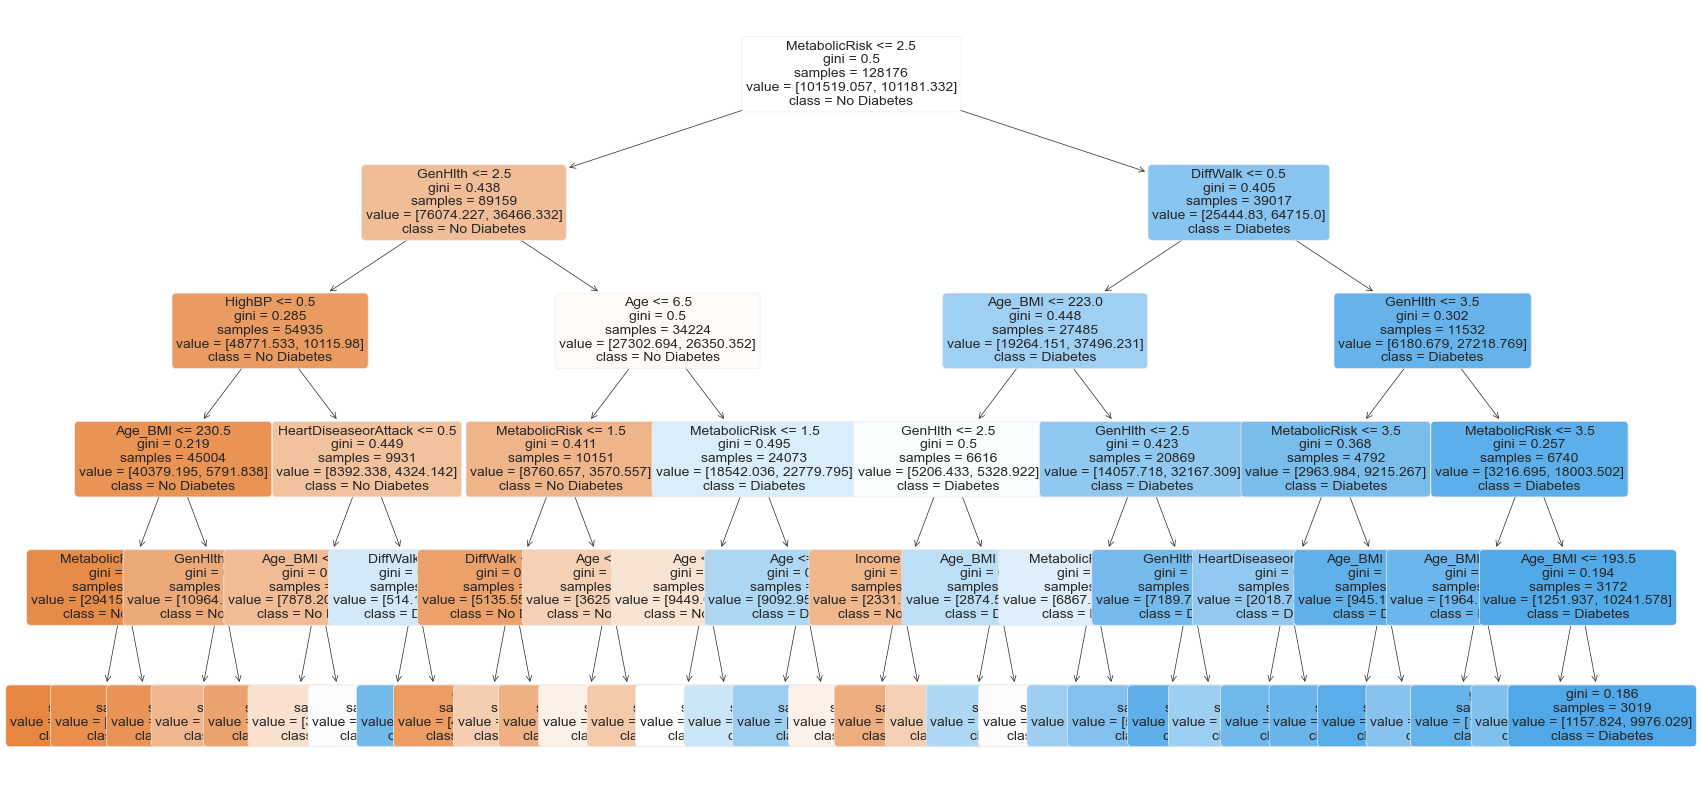

In [772]:
from sklearn.tree import export_text, plot_tree
import matplotlib.pyplot as plt

# Lấy một cây bất kỳ trong RandomForest
tree = best_rf.estimators_[0]  # cây đầu tiên

# --- Cách 1: Print text rules ---
r = export_text(tree, feature_names=list(X_train.columns))
print(r)

# --- Cách 2: Plot tree ---
plt.figure(figsize=(20,10))
plot_tree(tree, feature_names=X_train.columns, 
          class_names=['No Diabetes','Diabetes'], 
          filled=True, rounded=True, fontsize=10)
plt.show()


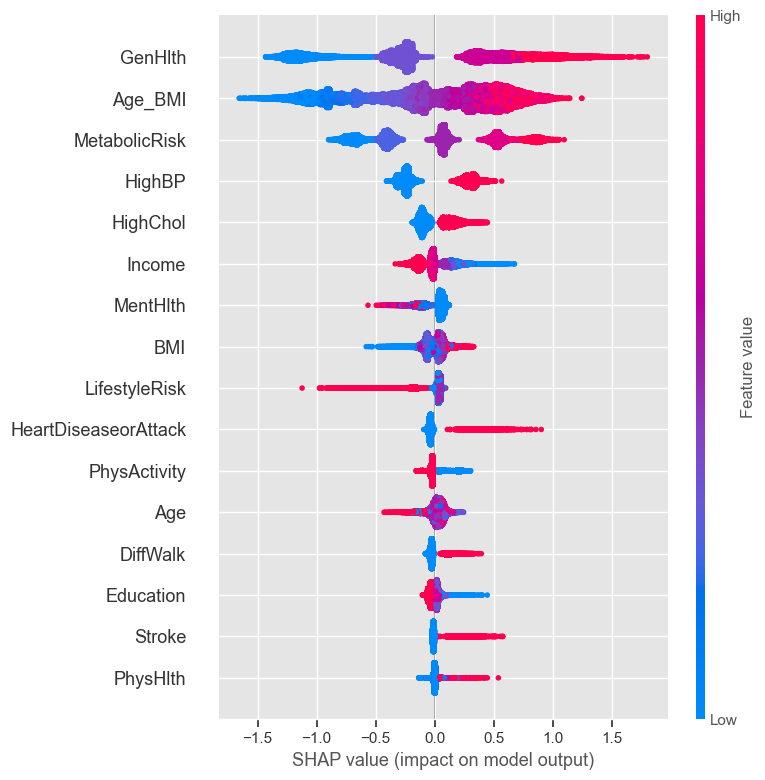

In [773]:
import shap

explainer = shap.TreeExplainer(best_hgb)  # hoặc best_xgb
shap_values = explainer.shap_values(X_test)

# Summary plot
shap.summary_plot(shap_values, X_test)


In [774]:
import graphviz
print(graphviz.__version__)

0.20.1


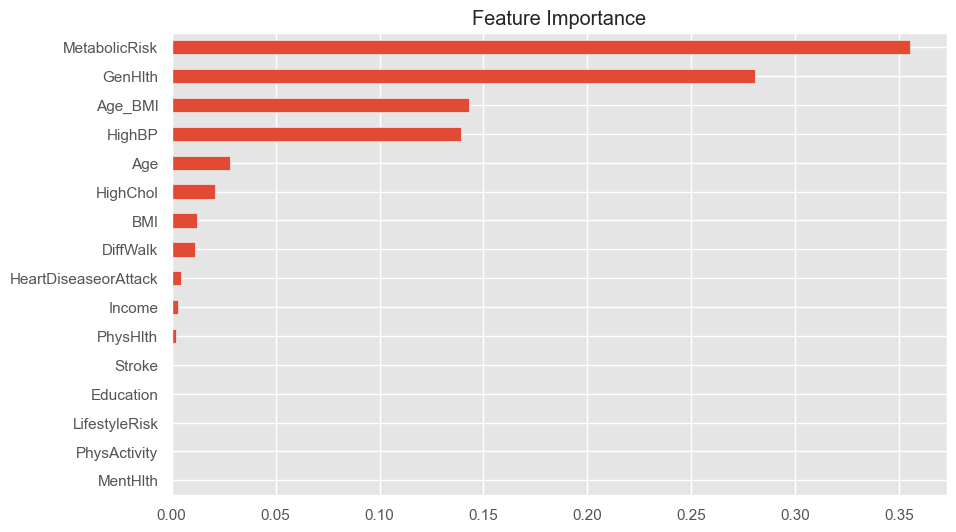

In [775]:
import pandas as pd
import matplotlib.pyplot as plt

feat_importance = pd.Series(best_rf.feature_importances_, index=X_train.columns)
feat_importance.sort_values().plot(kind='barh', figsize=(10,6))
plt.title("Feature Importance")
plt.show()

<Figure size 640x480 with 0 Axes>

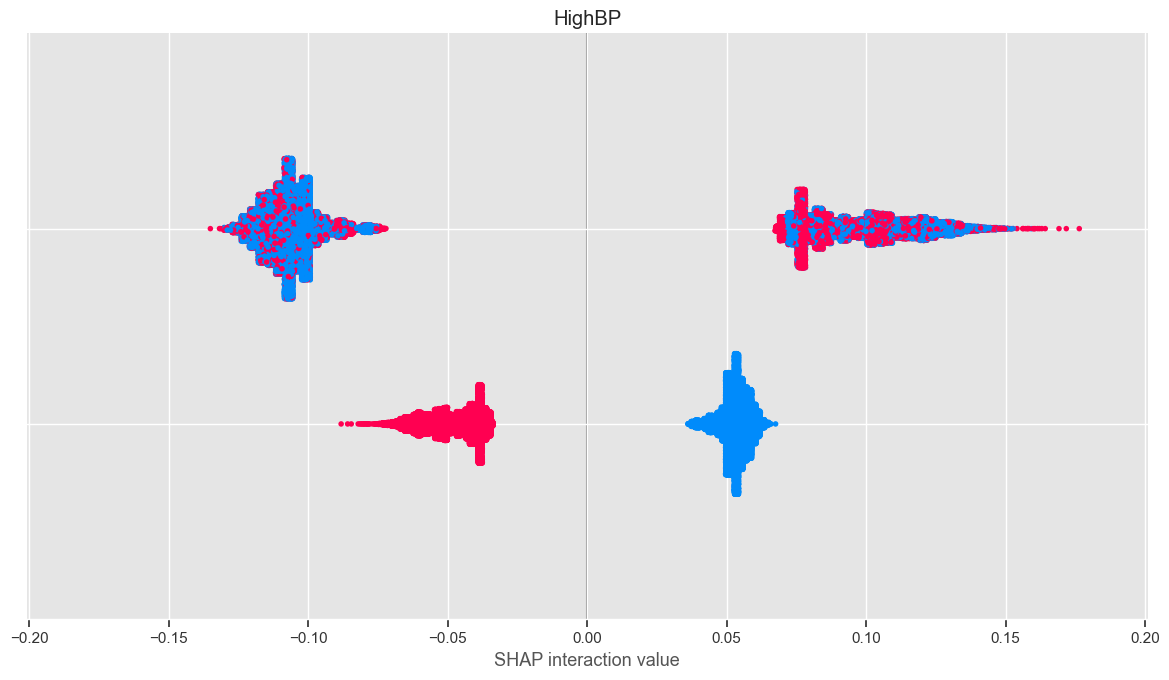

In [776]:
import shap

explainer = shap.TreeExplainer(best_rf)
shap_values = explainer.shap_values(X_test)

# Summary plot
shap.summary_plot(shap_values, X_test)


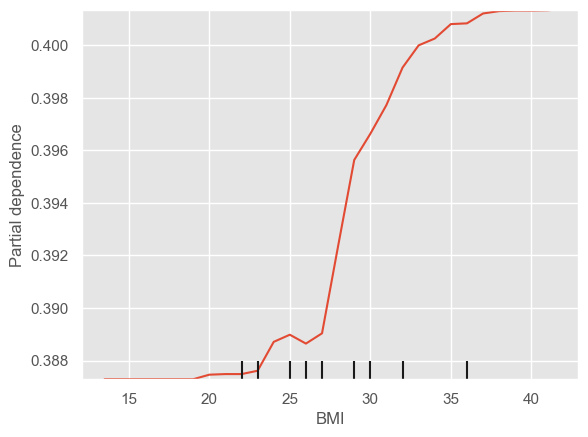

In [777]:
from sklearn.inspection import plot_partial_dependence

plot_partial_dependence(best_rf, X_train, features=["BMI"], feature_names=X_train.columns)
plt.show()
